In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [58]:
from tkinter import W
from trace import Trace
import pandas as pd
import numpy as np
import nltk
import pickle
import csv
import gensim
from tensorflow import keras
import gensim.downloader
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.sklearn_api import D2VTransformer
from gensim.sklearn_api import W2VTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [40]:
hate_data, hate_labels = [], [] 
with open("/content/drive/My Drive/Colab Notebooks/cs464/Project/dataset/hate_dataset", "rb") as fp:     
    hate_data= pickle.load(fp)
with open("/content/drive/My Drive/Colab Notebooks/cs464/Project/dataset/hate_labels", "rb") as fp:     
    hate_labels= pickle.load(fp)

In [43]:
#np.random.seed(500)
#data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cs464/Project/train_E6oV3.csv")
data = pd.DataFrame(hate_data)
labels = pd.DataFrame(hate_labels)

data[0].dropna(inplace=True)
data[0] = [entry.lower() for entry in data[0]] # all lowercase
data[0]= [word_tokenize(entry) for entry in data[0]] # tokenization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ #seperate adjectives
tag_map['V'] = wn.VERB #seperate verbs
tag_map['R'] = wn.ADV #seperate adverbs

In [44]:
for index,entry in enumerate(data[0]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    data.loc[index,'text_final'] = str(Final_words)
    
print("Finished preprocessing")

Finished preprocessing


In [45]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['text_final'],labels[0],test_size=0.3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

'''
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
'''

#Train Doc2Vec

In [ ]:
import gensim
import gensim.downloader as api
dataset = api.load("text8")
data = [d for d in dataset]

In [ ]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(data))

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
#model.save("/content/drive/My Drive/Colab Notebooks/cs464/Project/d2v.model")

In [ ]:
Train_X_d2v = list(map(model.infer_vector, Train_X))
Train_X_d2v[0]

In [114]:
#saved_model = gensim.models.doc2vec.Doc2Vec.load("/content/drive/My Drive/Colab Notebooks/cs464/Project/d2v.model")

In [ ]:
Text_X_d2v = list(map(model.infer_vector, Test_X))


In [ ]:
scaler = MinMaxScaler()
Train_X_d2v_scaled = scaler.fit_transform(Train_X_d2v)
Test_X_d2v_scaled = scaler.fit_transform(Text_X_d2v)


0.0

#Word2Vec

In [30]:
glove_vectors = gensim.downloader.load('glove-twitter-200'). # glove-twitter-25 

[==================================================] 100.0% 758.5/758.5MB downloaded


In [33]:
glove_vectors.save('/content/drive/My Drive/Colab Notebooks/cs464/Project/w2v.model')

In [7]:
#google_vectors = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/cs464/Project/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

In [ ]:
glove_vectors.wv.most_similar('king')

In [ ]:
words = set(glove_vectors.wv.vocab.keys() )
X_train_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])
                         for ls in Train_X])
X_test_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])
                         for ls in Test_X])

In [65]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [54]:
## for naive bayes
scaler = MinMaxScaler()
X_train_vect_avg = scaler.fit_transform(X_train_vect_avg)
X_test_vect_avg = scaler.fit_transform(X_test_vect_avg)

#MODELS

In [64]:
def print_metrics(prediction):
      print("Accuracy Score -> ",accuracy_score(prediction, Test_Y)*100)
      print("Precision -> ", precision_score(Test_Y, prediction, average="binary"))
      print("Recall -> ", recall_score(Test_Y, prediction, average="binary"))
      print("F1 Score -> ", f1_score(Test_Y, prediction, average="binary"))
      cm = confusion_matrix(Test_Y, predictions_NB, labels=[0, 1])
      group_names = ['TN','FP','FN','TP']
      group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
      labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, cm.flatten(), group_percentages)]
      labels = np.asarray(labels).reshape(2,2)
      sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
      plt.show()

SVM Accuracy Score ->  66.28962088253574
Precision ->  0.6583557089886204
Recall ->  0.9922913856234342
F1 Score ->  0.7915449654112222


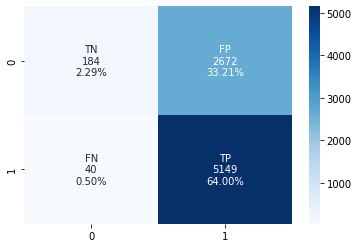

In [60]:
Naive = naive_bayes.MultinomialNB()

Naive.fit(X_train_vect_avg,Train_Y)
predictions_NB = Naive.predict(X_test_vect_avg)

print_metrics(predictions_NB)


Accuracy Score ->  71.32380360472344
Precision ->  0.710119568387285
Recall ->  0.9385238003468876
F1 Score ->  0.8085000415041089


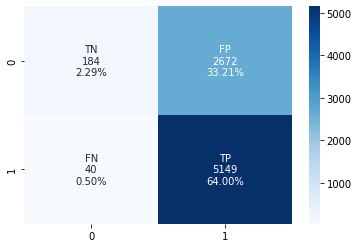

In [67]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

SVM.fit(X_train_vect_avg,Train_Y)
predictions_SVM = SVM.predict(X_test_vect_avg)

print_metrics(predictions_SVM)
  

Accuracy Score ->  75.09011808576756
Precision ->  0.7728285077951003
Recall ->  0.8693389863172095
F1 Score ->  0.8182477779793216


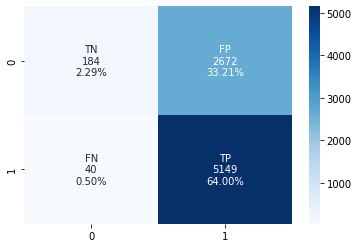

In [66]:
RFC = RandomForestClassifier()
RFC.fit(X_train_vect_avg, Train_Y)
predictions_RFC = RFC.predict(X_test_vect_avg)

print_metrics(predictions_RFC)